# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

import ml_metrics
import recmetrics
from random import sample

Let's now download our dataset. We will also unzip it for further use.

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2022-05-14 15:30:56--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   325KB/s    in 2.9s    

2022-05-14 15:30:59 (325 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Let's take a look at part of the ratings file to get an idea of the columns available.

In [2]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


As part of the dataset, there is also another file that contains movie information, which includes the movie id, the title, the genre, among others. We can INNER JOIN the ratings and movies datasets to gain access to all data we will need for our analysis.

Deleting the popular movies. Decreases training time and not really useful to know that everyone enjoys popular movies. Want to see actually personalized recs.
But can comment out this function call in the 4th cell.

In [16]:
def delete_popular_movies():
  global df
  global df_movies
  num_rated_movies = df['movieId'].value_counts()
  num_ratings_of_popular_movies = num_rated_movies.values[0] - 10 * num_rated_movies.std()
  popular_movies = num_rated_movies[num_rated_movies > num_ratings_of_popular_movies].keys()
  df = df[~df['movieId'].isin(popular_movies)]
  df_movies = df_movies[~df_movies['movieId'].isin(popular_movies)]

In [4]:
df_movies = pd.read_csv('ml-latest-small/movies.csv')

delete_popular_movies()

df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join.head()

,movieId,title,genres,userId,rating,timestamp
0,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
1,3,Grumpier Old Men (1995),Comedy|Romance,6,5.0,845554296
2,3,Grumpier Old Men (1995),Comedy|Romance,19,3.0,965707636
3,3,Grumpier Old Men (1995),Comedy|Romance,32,3.0,856736172
4,3,Grumpier Old Men (1995),Comedy|Romance,42,4.0,996221045


Let's now prepare our sparse review matrix. For this purpose, we first need to find out how many users and movies we have in our dataset. Additionally, we will set D to 5 dimensions.

In [5]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 0])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

Let's now call this function and retrieve all necessary parameters.

In [6]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [7]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [8]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [9]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [10]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [11]:
def rmse_evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

In [31]:
def rec_evaluate(dataset, metric_type):
    all_actuals, all_predictions = [], []
    movie_to_column_items = np.array(list(movie_to_column.items()))

    users = sample(list(np.unique(dataset['userId'])), 100)
    for idx, user_id in enumerate(users):
        actual_likes = df_join[df_join['userId'] == user_id][['movieId', 'rating']].sort_values(by=['rating'], ascending=False)
        # cut off where rating 4's end
        actual_likes = actual_likes[actual_likes['rating'] >= 4.0]['movieId'].values
        # actual_likes = actual_likes.head(10)['movieId'].values
        predictions = np.zeros((n_movies, 1))

        for i, movie in enumerate(movie_to_column_items):
            predictions[i] = predict(user_id, movie[0])
            
        indices = np.argsort(-predictions, axis=0)

        predicted_likes = []
        for j in range(10):
            movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
            predicted_likes.append(movie_id)
        all_actuals.append(list(actual_likes))
        all_predictions.append(predicted_likes)

    if metric_type == "MAPK":
        return ml_metrics.mapk(all_actuals, all_predictions, 10)
    elif metric_type == "MARK":
        return recmetrics.mark(all_actuals, all_predictions, 10)
    elif metric_type == "PER":
        return recmetrics.prediction_coverage(all_predictions, list(np.unique(dataset['movieId'])))
    else:
        raise Exception("Evaluating on invalid metric type.")

For the purposes of scaling, we need the maximum and minimum rating values.

In [13]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [32]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train, rmse_test = [], []
    mapk_train, mapk_test = [], []
    mark_train, mark_test = [], []
    per_train, per_test = [], []

    update_max_min_ratings()
    rmse_train.append(rmse_evaluate(train_set))
    rmse_test.append(rmse_evaluate(test_set))
    mapk_train.append(rec_evaluate(train_set, 'MAPK'))
    mapk_test.append(rec_evaluate(test_set, 'MAPK'))
    mark_train.append(rec_evaluate(train_set, 'MARK'))
    mark_test.append(rec_evaluate(test_set, 'MARK'))
    per_train.append(rec_evaluate(train_set, 'PER'))
    per_test.append(rec_evaluate(test_set, 'PER'))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(rmse_evaluate(train_set))
            rmse_test.append(rmse_evaluate(test_set))
            mapk_train.append(rec_evaluate(train_set, 'MAPK'))
            mapk_test.append(rec_evaluate(test_set, 'MAPK'))
            mark_train.append(rec_evaluate(train_set, 'MARK'))
            mark_test.append(rec_evaluate(test_set, 'MARK'))
            per_train.append(rec_evaluate(train_set, 'PER'))
            per_test.append(rec_evaluate(test_set, 'PER'))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test, mapk_train, mapk_test, mark_train, mark_test, per_train, per_test

Let's train our model!

In [34]:
log_ps, rmse_train, rmse_test, mapk_train, mapk_test, mark_train, mark_test, per_train, per_test = train(100)

Log p a-posteriori at iteration 10 : -23716.97145848338


Now let's take a look at some graphs

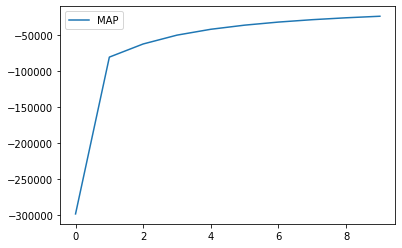

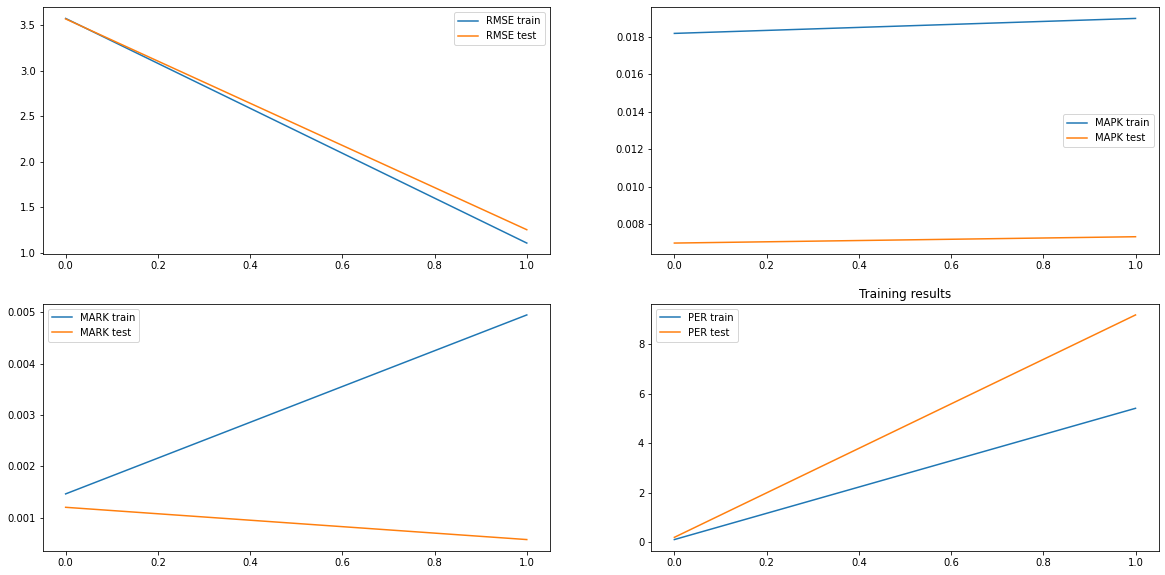

In [35]:
plt.plot(np.arange(len(log_ps)), log_ps, label='MAP')
plt.legend()

_, axes = plt.subplots(2, 2, figsize=(20, 10))
plt.title('Training results')

axes[0, 0].plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
axes[0, 0].plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
axes[0, 0].legend()

axes[0, 1].plot(np.arange(len(mapk_train)), mapk_train, label='MAPK train')
axes[0, 1].plot(np.arange(len(mapk_test)), mapk_test, label='MAPK test')
axes[0, 1].legend()

axes[1, 0].plot(np.arange(len(mark_train)), mark_train, label='MARK train')
axes[1, 0].plot(np.arange(len(mark_test)), mark_test, label='MARK test')
axes[1, 0].legend()

axes[1, 1].plot(np.arange(len(per_train)), per_train, label='PER train')
axes[1, 1].plot(np.arange(len(per_test)), per_test, label='PER test')
axes[1, 1].legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [36]:
print('RMSE of training set:', rmse_evaluate(train_set))
print('RMSE of testing set:', rmse_evaluate(test_set))
print('MAPK of training set:', rec_evaluate(train_set, 'MAPK'))
print('MAPK of testing set:', rec_evaluate(test_set, 'MAPK'))
print('MARK of training set:', rec_evaluate(train_set, 'MARK'))
print('MARK of testing set:', rec_evaluate(test_set, 'MARK'))
print('PERSONALIZATION of training set:', rec_evaluate(train_set, 'PER'))
print('PERSONALIZATION of testing set:', rec_evaluate(test_set, 'PER'))

RMSE of training set: 1.1066440183206396
RMSE of testing set: 1.253353548771681
MAPK of training set: 0.008714682539682541
MAPK of testing set: 0.00715515873015873
MARK of training set: 0.0005023215049414016
MARK of testing set: 0.003029860099269318
PERSONALIZATION of training set: 5.19
PERSONALIZATION of testing set: 9.42
